In [1]:
from rl_agent import Agent # own implementations
from rl_environment import GridWorld # own implementations
from rl_render import Render # own implementations
import numpy as np 
import matplotlib.pyplot as plt
import logging
import warnings
import copy

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(finame)s - %(lineno)d - %(levelname)s : %(message)s',
                     datefmt='%H:%M:%S')
logger = logging.getLogger('my-logger')
# logger.propagate = False
logger.disabled = True

# ploting settings
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True

In [2]:
def init_env(config=0):
    # creating simple grid
    if config==0:
        world = GridWorld(6,6,
                setRewards= {'default': -0.02},
                environmentDynamics='stochastic')
        
        # adding more complexity to the grid (terrains and goals)
        world.addTerminal(('goal',[(0,5),(5,2)]),
                        ('negative_goal',[(2,4)]))
        world.addTerrain(('wall',[(0,2),(1,2),(4,2),(5,0),(5,1)]),
                        ('shortcut', [(1,1),(1,3)]))
    else:
        world = GridWorld(5,5,
                setRewards= {'default': -0.02},
                environmentDynamics='stochastic')
        
        # adding more complexity to the grid (terrains and goals)
        world.addTerminal(('goal',[(4,2)]),
                        ('negative_goal',[(2,4)]))
        world.addTerrain(('wall',[(0,2),(3,2),(4,0),(4,1)]),
                        ('shortcut', [(1,1),(1,3)]))

    return world

# train using value iteration
def value_iteration(agent:Agent, world:GridWorld, render:Render, gamma, theta, ignore_converged_s, episodes):
    for episode in episodes: 
        _ , iterations = agent.valueIteration(world, max_iterations=episode, gamma=gamma, theta=theta , ignore=ignore_converged_s) 
        render.renderEnv(style='image', results=True,
            title=f'value iteration:\n gamma:{gamma},theta:{theta},ignore:{ignore_converged_s},converged_in={iterations}')

# train using MC estimates policy evaluation   
def MC_estimate_policy_evaluation(agent:Agent, world:GridWorld, render:Render, gamma, max_steps_per_iteration, episodes):
    for episode in episodes: # MC estimates policy evaluation
        agent.policy = agent.policyGenerator(world)
        agent.evaluatePolicyLoop_MC(world, policy=agent.policy, samples=episode , max_steps=max_steps_per_iteration)
        agent.policy = agent.updatePolicy(world)
        render.renderEnv(style='color map', results=True,
        title=f'MC estimates on heuristic policy:\n gamma:{gamma},max_stpPerIter:{max_steps_per_iteration},episodes={episode}')

# train using general policy iteration
def policy_iteration(agent:Agent, world:GridWorld, render:Render, gamma, theta,episodes,s_per_i=200,rtol=0.2,style='color map', method='DP'):
    for episode in episodes: # policy iteration # TODO: fix policy iteration
        agent.reset(world)
        heuristic_pi = agent.policyGenerator(world)
        if method=='MC':
            policy , iterations = agent.MC_policyIteration(world,policy=heuristic_pi, max_iterations=episode, gamma=gamma,
                                                        converge_condition='close',steps_per_iter=s_per_i ,rtol=rtol)
        elif method=='DP':
            policy , iterations = agent.DP_policyIteration(world,policy=heuristic_pi, max_iterations=episode, gamma=gamma,
                                                        converge_condition='close',steps_per_iter=s_per_i ,rtol=rtol)
        else:
            logging.info('please pick a method for the policy iteration algorithem. Options : [ "MC" , "DP" ]')    
        agent.policy = agent.prob_to_determin_policy(world, agent.policy, method='greedy')
        render.renderEnv(style=style, results=True,
        title=f'policy iteration: {method}\n gamma:{gamma},theta:{theta},converged_in={iterations} from max {episode}')


rl_agent.py - 444 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########
rl_agent.py - 444 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########
rl_agent.py - 444 - INFO : ######## ----------- START MC POLICY ITERATION ------------------##########
rl_agent.py - 351 - INFO : ######## ----------- START DP POLICY ITERATION ------------------##########
rl_agent.py - 351 - INFO : ######## ----------- START DP POLICY ITERATION ------------------##########
rl_agent.py - 351 - INFO : ######## ----------- START DP POLICY ITERATION ------------------##########


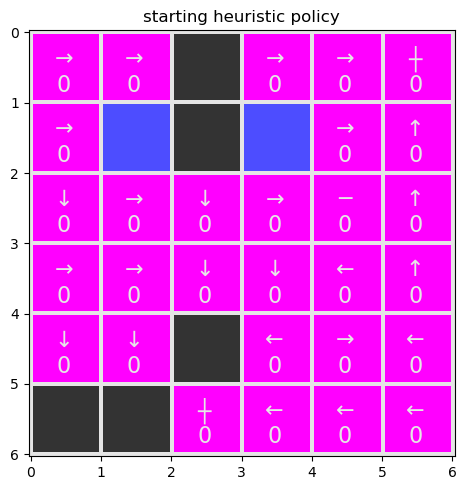

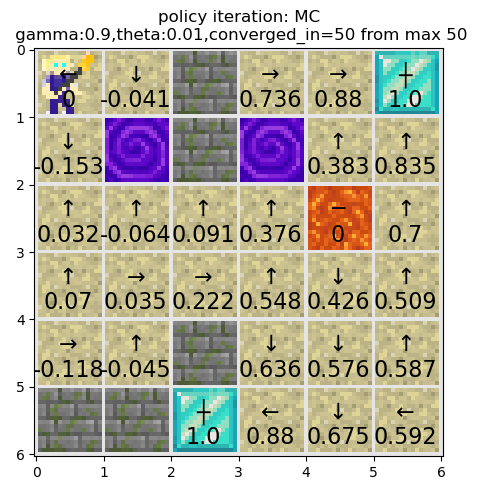

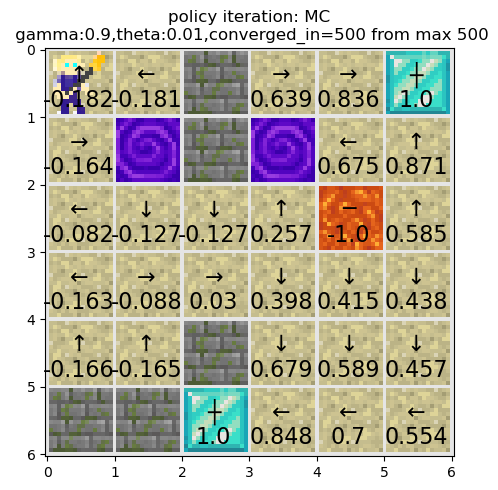

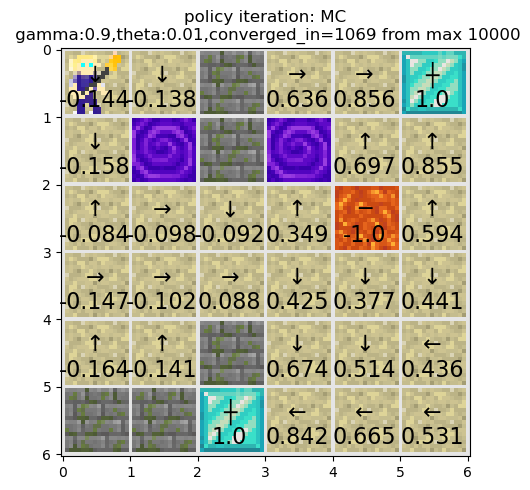

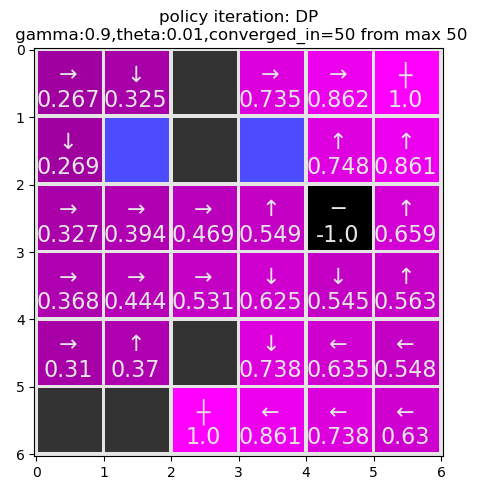

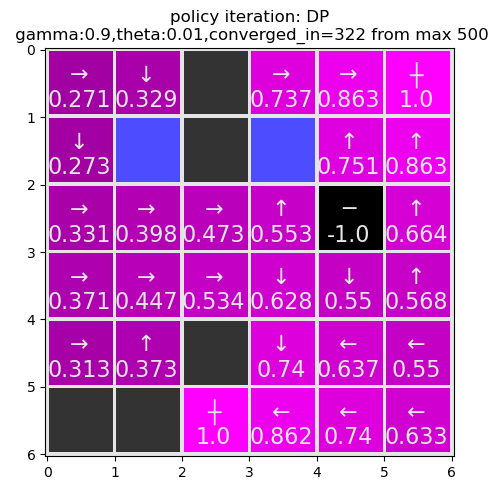

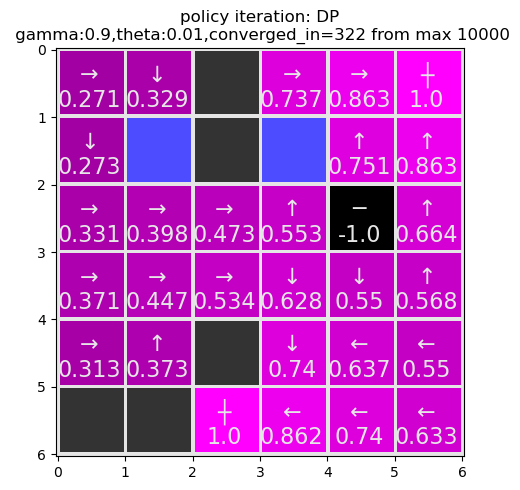

134272941.py - 42 - INFO : ############################## Done ##############################


In [3]:
# variables for training
episodes_list = [50,200,500,1000,10000]
gamma=0.9
epsilon=0.01
ignore_converged_s=0.2 
max_steps_per_iteration=200 
relativ_tolerance = 1e-3 # the accurecy for testing for policy convergence

# creating an environment
world = init_env(config=0)

# creating an agent in the gridworld
agent = Agent(environment=world)

# creating render object 
render = Render(env=world, agent=agent)

# initiate rendering resources
render.init_rendering_resources(configuration=0)
# render.start()

# starting heuristic policy
heuristic_pi = agent.policyGenerator(world)
agent.policy = agent.prob_to_determin_policy(world, heuristic_pi)
render.renderEnv(style='color map', results=True, title=f'starting heuristic policy')

# trainig a model for x episodes with different methods

# value_iteration(agent,world,render,gamma,epsilon,ignore_converged_s,episodes=[10,100,10000])
# MC_estimate_policy_evaluation(agent,world,render,gamma,max_steps_per_iteration,episodes=[10,100,10000])

# play around with the relative torelance / absolute tolerance (atol) for prolonging/shortening the convergence
policy_iteration(agent,world,render,gamma,epsilon,episodes=episodes_list[::2],s_per_i=max_steps_per_iteration,
                 rtol=relativ_tolerance,style='image',method='MC')
policy_iteration(agent,world,render,gamma,epsilon,episodes=episodes_list[::2],s_per_i=max_steps_per_iteration,
                 rtol=relativ_tolerance,method='DP')


# render.end()
render.show()

logging.info('############################## Done ##############################')